In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import random
import imageio
import sys
import os

In [2]:
# Some constant definition
P  = 8   # total num. of ranks/processes
T  = 40  # total num. of tasks
Ti = 5   # num. tasks per rank
w  = 5   # wallclock time per task

# ----------------------------------------
# Total load per rank
# ----------------------------------------
def estimate_total_load():
    load_arr = []
    for i in range(P):
        Li = Ti * w
        load_arr.append(Li)
    return load_arr

# ----------------------------------------
# Performance Slowdown
# ----------------------------------------
def slowdown_performance(slow, n_impact_processes):
    speed_arr = []
    for i in range(P):
        if i < n_impact_processes:
            SPi = 1.0 + slow
            speed_arr.append(SPi)
        else:
            SPi = 1.0 + 0.0
            speed_arr.append(SPi)
    return speed_arr

def random_slowdown_performance(niter, nprocesses):
    speed_arr = []
    for iter in range(niter):
        tmp_speed = []
        if iter == 0: # keep the balanced perf
            for i in range(P):
                SPi = 1.0 + 0.0
                tmp_speed.append(SPi)
        else: # randomly slowdown the load
            rand_npro = random.randint(1, nprocesses/2)
            for i in range(P):
                if i <= rand_npro:
                    rand_slow = random.uniform(1.0, 20.0)
                    SPi = 1.0 + rand_slow
                    tmp_speed.append(SPi)
                else:
                    SPi = 1.0 + 0.0
                    tmp_speed.append(SPi)
        speed_arr.append(tmp_speed)
    
    return speed_arr
            

In [3]:
# Some heatmap util functions

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [7]:
# For checking the slowdown performance function
LOAD = estimate_total_load()
S = slowdown_performance(8, 2)
print('------------------------------------')
print('Arr. slowdown perf:')
print(S)
print('------------------------------------')
L = np.array(LOAD) * np.array(S)
print('Arr. total load after slowing down:')
print(L)
print('------------------------------------')

# Calculate imbalance ratio
Lmax = np.max(L)
Lmin = np.min(L)
Lavg = np.average(L)
Rimb = Lmax/Lavg - 1
std  = np.std(L)
print('Lmax, Lavg: ', Lmax, Lavg)
print('Rimb: ', Rimb)
print('Std: ', std)

------------------------------------
Arr. slowdown perf:
[9.0, 9.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
------------------------------------
Arr. total load after slowing down:
[225. 225.  25.  25.  25.  25.  25.  25.]
------------------------------------
Lmax, Lavg:  225.0 75.0
Rimb:  2.0
Std:  86.60254037844386


------------------------------------
------------------------------------
------------------------------------
[0.0, 2.103602155638011, 2.609555855852077, 1.5158689779121617, 1.3360718721662241, 1.8267057747451396, 2.318965516652757, 2.3500849525561764, 0.9556273924756731, 0.8863699323213623, 1.2728156334867182, 1.3754341892539133, 1.806338867885136, 1.4782497284049834, 3.123888078552855, 1.0273231325702041, 1.6011813501073693, 1.6491520610821389, 3.6196619786502042, 1.890283965154365, 1.2792604241383905, 3.6778267717529527, 1.5337236781166026, 2.25547787400566, 1.8838556540636509, 3.3523224887209944, 2.964059942909847, 1.6575924366052779, 1.8173478450472254, 1.7778338293123115, 3.023553762621993, 2.320502814996505, 3.2422955780900695, 1.5414766936424997, 1.7909961044550111, 1.475420110382867, 1.2510228551531517, 1.0116525665941438, 2.5988684011661576, 1.0883105461741303, 2.217830203686404, 1.8858275838590561, 1.3004821543047487, 2.2832190801962318, 0.9712580372466952, 1.43815093855273

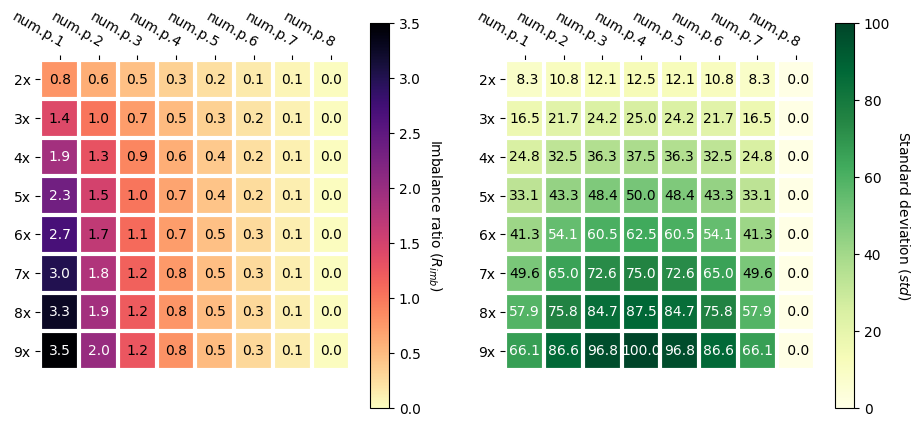

In [8]:
# ----------------------------------------
# Main
# ----------------------------------------
if __name__ == '__main__':
    
    # Set slowdown coefficient
    slow_set = np.arange(1.0, 9.0, 1.0, dtype=float)
    
    # Init a given load
    LOAD = estimate_total_load()
    
    # Slowdown load array
    SLOW_LOAD_ARR = []
    RIMB_MAT = []
    STDV_MAT = []
    
    # Generate random slowdown and Rimb over 100 iters of execution
    print('------------------------------------')
    S_arr = random_slowdown_performance(100, P)
    L_arr = []
    for i in range(len(S_arr)):
        L_tmp = np.array(LOAD) * np.array(S_arr[i])
        L_arr.append(L_tmp)
    
    # Calculate the Rimb ratios
    print('------------------------------------')
    Rimb_arr = []
    Std_arr = []
    for i in range(len(L_arr)):
        Lmax = np.max(L_arr[i])
        Lmin = np.min(L_arr[i])
        Lavg = np.average(L_arr[i])
        Rimb_arr.append(Lmax/Lavg - 1)
        Std_arr.append(np.std(L_arr[i]))
    print('------------------------------------')
    print(Rimb_arr)
    print(Std_arr)
    
    
    # Slowdown the performance
    for i in slow_set:
        tmp_rimb = []
        tmp_stdv = []
        for n in range(P):
            S = slowdown_performance(i, n+1)
            L = np.array(LOAD) * np.array(S)
            # print(L)
            
            # Calculate imbalance ratio
            Lmax = np.max(L)
            Lmin = np.min(L)
            Lavg = np.average(L)
            Rimb = Lmax/Lavg - 1
            std  = np.std(L)
            
            # append rimb and std value for each case
            tmp_rimb.append(Rimb)
            tmp_stdv.append(std)
            
        RIMB_MAT.append(tmp_rimb)
        STDV_MAT.append(tmp_stdv)
    print('------------------------------------')

    # Display a given distribution
    print('Num. ranks: ', P)
    print('Num. tasks: ', T)
    print('Num. tasks per rank: ', Ti)
    print('Task runtime: ', w)
    
    print('------------------------------------')
    print('Checking the table of Rimb values: ')
    print(RIMB_MAT)
    print('------------------------------------')
    print('Checking the table of std values: ')
    print(STDV_MAT)
    print('------------------------------------')
    
    # Plot heatmap
    gs = gridspec.GridSpec(1,2)
    fig = plt.figure(figsize=(11,5))
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    # Heatmap 1
    num_ranks = ["num.p.1", "num.p.2", "num.p.3", "num.p.4", "num.p.5", "num.p.6", "num.p.7", "num.p.8"]
    slowdown = ["2x", "3x", "4x", "5x", "6x", "7x", "8x", "9x"]
    data1 = np.array(RIMB_MAT)
    im1, cbar1 = heatmap(data1, slowdown, num_ranks, ax=ax1, cmap="magma_r", cbarlabel="Imbalance ratio ($R_{imb}$)")
    texts1 = annotate_heatmap(im1, valfmt="{x:.1f}")
    # Heatmap 2
    data2 = np.array(STDV_MAT)
    im2, cbar2 = heatmap(data2, slowdown, num_ranks, ax=ax2, cmap="YlGn", cbarlabel="Standard deviation ($std$)")
    texts2 = annotate_heatmap(im2, valfmt="{x:4.1f}")

    # fig.tight_layout()
    # plt.show()
    
    # save the figure
    fig_filename = "./heatmap_slowdown_impact.pdf"
    plt.savefig(fig_filename, bbox_inches='tight')
    print('Already saved the figure at ' + fig_filename)
    print('------------------------------------')
    
    

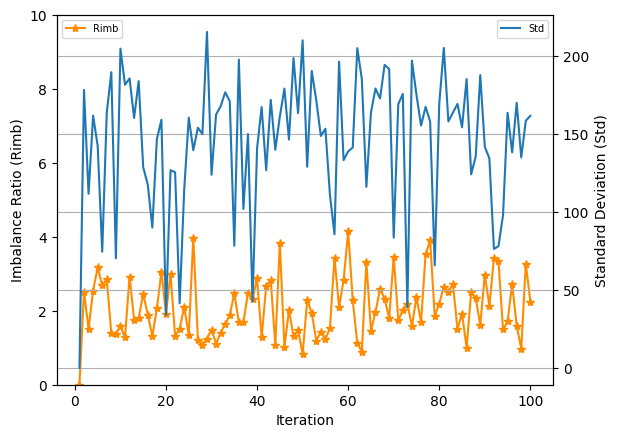

In [35]:
# ---------------------------------------------------------
# Line styles
# ---------------------------------------------------------
lstyles = ['solid', 'solid']
ldashstyles = ['dashed', 'dashed']
lcolors = ['black', 'blue', 'darkgreen', 'red', 'darkorange', 'purple', 'teal']
lmarkers = ['*', '^', 'o', 's', 'P', 'p', 'd']

fig, ax1 = plt.subplots()
ax1_indices = np.arange(1, len(Rimb_arr)+1)
ax1.plot(ax1_indices, Rimb_arr, label='Rimb', linestyle='solid', marker='*', color='darkorange')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Imbalance Ratio (Rimb)")
ax1.set_ylim(0, 10)
ax1.legend(loc="upper left", fontsize=7)

ax2 = ax1.twinx()
ax2_indices = np.arange(1, len(Rimb_arr)+1)
ax2.plot(ax1_indices, Std_arr, label='Std', linestyle='solid')
ax2.set_ylabel("Standard Deviation (Std)")
ax2.legend(loc="upper right", fontsize=7)

plt.grid()
# plt.show()

# save the figure
fig_filename = "./double_line_random_slowdown.pdf"
plt.savefig(fig_filename, bbox_inches='tight')